## Sampling Importance Resampling

## 

### Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import lognorm, poisson, norm
from rpy2.robjects import r
from rpy2.robjects.packages import importr
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from scipy import integrate

In [2]:
# conda install -c r rpy2
# conda install -c r r-VGAM

### Import VGAM from r

In [3]:
vgam = importr('VGAM')

# Q1.

### Initial values

In [4]:
m = 100000
n = 5000
y = np.random.normal(0, 1, m)
v = vgam.rslash(m)

### Weights Functions

In [5]:
def w1(x,mu, sigma):
    out = vgam.dslash(x)/norm.pdf(x,mu, sigma)
    out = out/sum(out)
    return out

def w2(x,mu,sigma):
    out = norm.pdf(x,mu, sigma)/vgam.dslash(x)
    out = out/sum(out)
    return out

In [6]:
rpy2.robjects.numpy2ri.activate()
Y = ro.r.matrix(y)
V = ro.r.matrix(v)

### Weights Calculation and sampling

In [7]:
weights1 = np.reshape(np.array(w1(Y,0,1)),m)
v = np.reshape(np.array(V),m)
x = np.random.choice(y, size = n, replace=True, p=weights1)

weights2 = np.reshape(np.array(w2(V,0,1)),m)
u = np.random.choice(v, size = n, replace=True, p=weights2)

In [8]:
x

array([ 4.33222215, -4.3472422 ,  4.33222215, ...,  0.07019297,
       -0.69203703,  1.46904362])

In [9]:
u

array([ 1.58373231, -0.62827898, -1.6523596 , ..., -0.82432404,
        0.39154571, -0.23264959])

### Plot

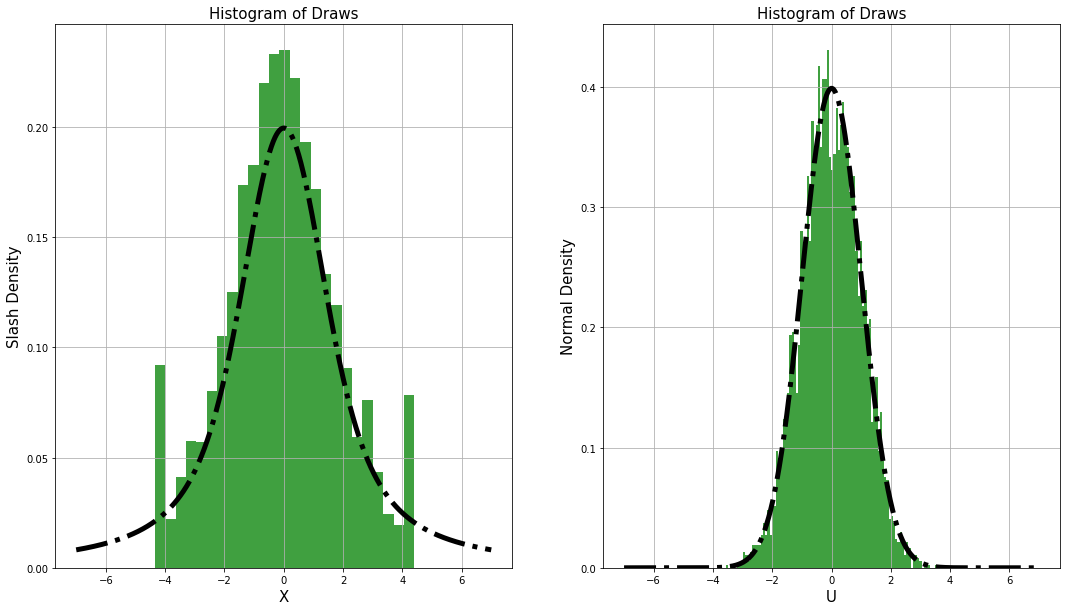

In [10]:
y = vgam.dslash(np.linspace(-7, 7,n))
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.hist(x, 25, density=True, facecolor='g', alpha=0.75)
plt.plot(np.linspace(-7, 7,n),np.array(y), '-.', color='black', label='No mask',lw=5)
plt.xlabel('X',fontsize=15)
plt.ylabel('Slash Density',fontsize=15)
plt.title('Histogram of Draws',fontsize=15)
plt.grid(True)
y = norm.pdf(np.linspace(-7, 7,n))
plt.subplot(1,2,2)
plt.hist(u, 100, density=True, facecolor='g', alpha=0.75)
plt.plot(np.linspace(-7, 7,n),np.array(y), '-.', color='black', label='No mask',lw=5)

plt.xlabel('U',fontsize=15)
plt.ylabel('Normal Density',fontsize=15)
plt.title('Histogram of Draws',fontsize=15)
plt.grid(True)
plt.show()

# Q2.

### Data

In [11]:
n = 5000
X = np.array([8, 3, 4, 3, 1, 7, 2, 6, 2, 7])

### Defining random state

In [12]:
r = np.random.RandomState(1234)

### 100000 samples from lognormal distribution 

In [13]:
sample = r.lognormal(np.log(4),.5,100000)

### Likelihood

In [14]:
def Likelihood(sample,X):
    L = np.zeros(len(sample))
    for i in range(0,len(sample)):
        L[i] = np.prod(poisson.pmf(X,sample[i]))
    return L    

### Generated Random samples

In [15]:
L = Likelihood(sample,X)
f= np.random.choice(sample, size = n, replace=True, p=L/sum(L))

### Posterior 

In [16]:
lmbda = np.linspace(2,7,100)
c = integrate.simps(lognorm.pdf(lmbda,np.log(4), loc=0.5,scale=np.log(4))*Likelihood(lmbda,X),lmbda)
posterior = lognorm.pdf(lmbda,np.log(4), loc=0.5,scale=np.log(4))*Likelihood(lmbda,X)/c

### Plot

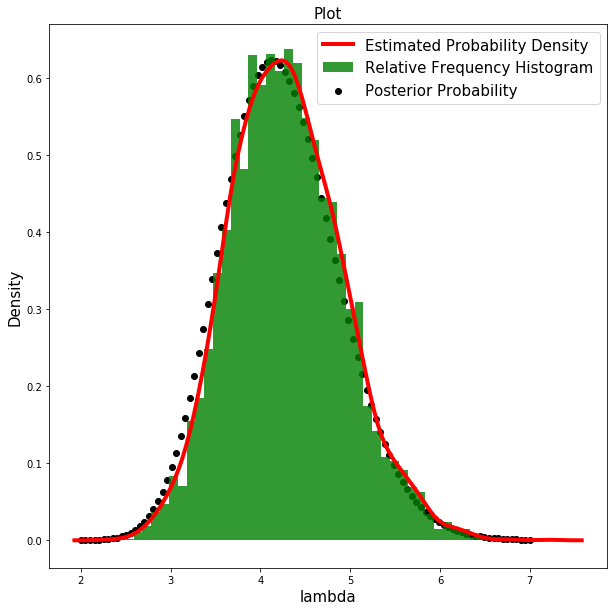

In [17]:
plt.figure(figsize=(10,10))
sns.distplot(f,kde=True,kde_kws={"color": "r", "lw": 4, "label": "Estimated Probability Density"},
            hist_kws={"label": "Relative Frequency Histogram", "linewidth": 35,
                            "alpha": 0.8, "color": "g"})
plt.scatter(lmbda,posterior,marker='o',c='k',label='Posterior Probability')
plt.legend(fontsize=15)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Plot',fontsize=15)
plt.show()

### Estimated Posterior Mean

In [18]:
np.mean(f)

4.287931305050212

### Estimated Posterior Standard Deviation

In [19]:
np.std(f)

0.6266224365115021